In [11]:
import psycopg2
import pandas as pd
import numpy as np

def process_two_signals(signal_1_df, signal_2_df, threshold):
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="yourpassword",
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()

    # Validate inputs
    if signal_1_df.empty or signal_2_df.empty:
        raise ValueError("Input DataFrames must not be empty.")
    if not all(col in signal_1_df.columns for col in ['ts', 'values']):
        raise ValueError("signal_1_df must contain 'ts' and 'values' columns.")
    if not all(col in signal_2_df.columns for col in ['ts', 'values']):
        raise ValueError("signal_2_df must contain 'ts' and 'values' columns.")

    # Convert to lists
    signal_1_ts = signal_1_df['ts'].tolist()
    signal_1_values = signal_1_df['values'].tolist()
    signal_2_ts = signal_2_df['ts'].tolist()
    signal_2_values = signal_2_df['values'].tolist()

    try:
        cur.execute(
            """
            SELECT * FROM process_two_signals(%s::float[], %s::float[], %s::float[], %s::float[], %s);
            """,
            (signal_1_ts, signal_1_values, signal_2_ts, signal_2_values, threshold)
        )
        result = cur.fetchall()
        # Convert the result into a Pandas DataFrame
        if result:
            df = pd.DataFrame(result, columns=["ts", "summed_value"])
            return df
        else:
            return pd.DataFrame(columns=["ts", "summed_value"])
    finally:
        cur.close()
        conn.close()

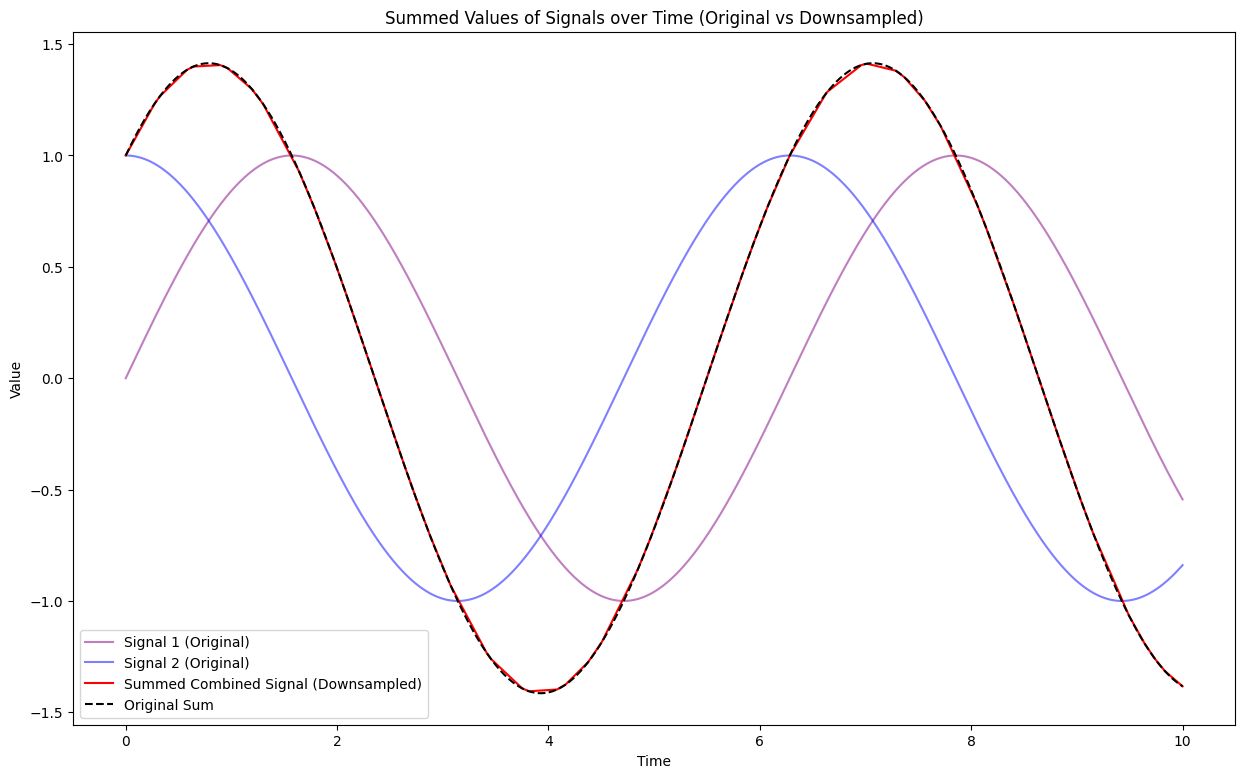

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate signals
np.random.seed(42)
number = 500000
time = np.linspace(0, 10, number)
signal_1 = np.sin(time)
signal_2 = np.cos(time)

# Create DataFrames for the signals
df_signal_1 = pd.DataFrame({
    "ts": time,
    "values": signal_1
})

df_signal_2 = pd.DataFrame({
    "ts": time,
    "values": signal_2
})

# Compute the original sum for comparison
original_sum = signal_1 + signal_2

# Process and merge the signals using the PostgreSQL function
threshold = 30  # Downsample to 1000 points
merged_df = process_two_signals(df_signal_1, df_signal_2, threshold)

# Plot the original, summed, and merged signals
plt.figure(figsize=(15, 9))

# Plot original signals
plt.plot(df_signal_1['ts'], df_signal_1['values'], color='purple', label='Signal 1 (Original)', alpha=0.5)
plt.plot(df_signal_2['ts'], df_signal_2['values'], color='blue', label='Signal 2 (Original)', alpha=0.5)

# Plot merged signals
plt.plot(merged_df['ts'], merged_df['summed_value'], color='red', label='Summed Combined Signal (Downsampled)')

# Plot the original sum
plt.plot(time, original_sum, color='black', label='Original Sum', linestyle='--')

# Finalize the plot
plt.title('Summed Values of Signals over Time (Original vs Downsampled)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

RMSE: 2.7648421233851617e-07
MAE: 2.140607339196268e-07
R-squared: 0.9999999999999254


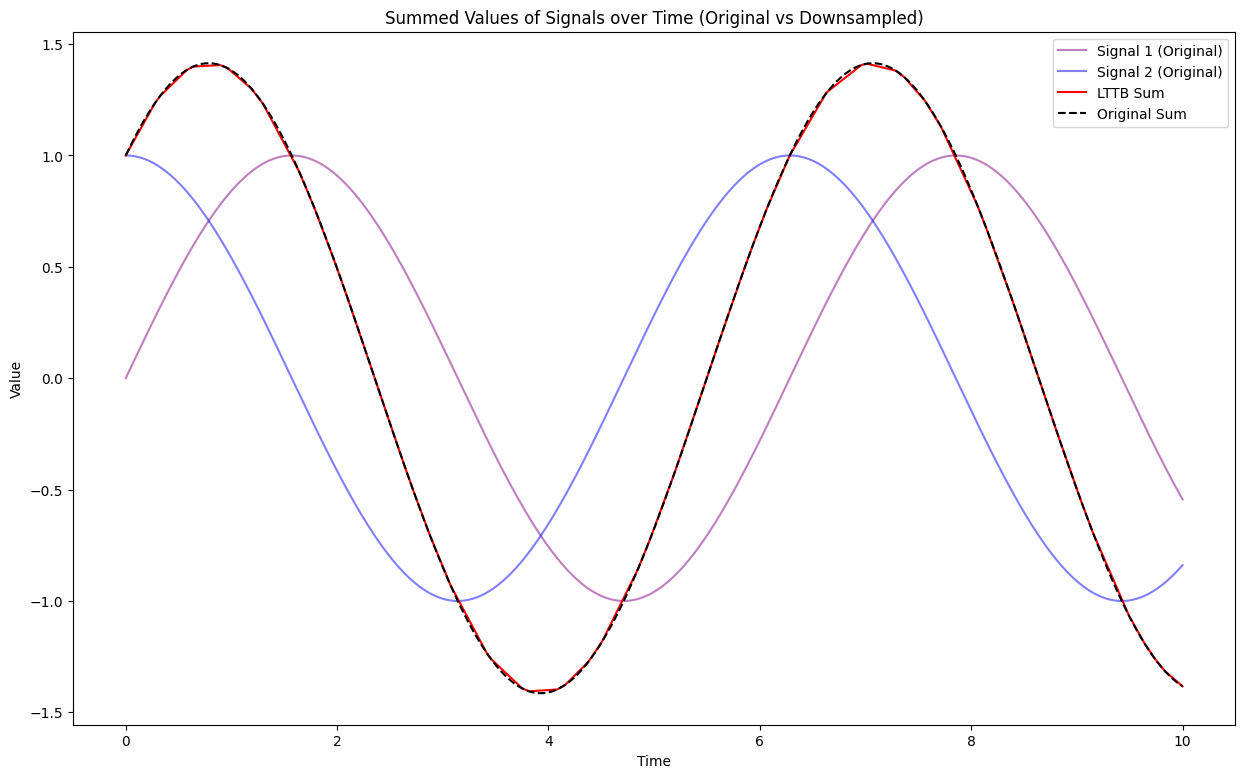

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate signals
np.random.seed(42)
number = 500000
time = np.linspace(0, 10, number)
signal_1 = np.sin(time)
signal_2 = np.cos(time)

# Create DataFrames for the signals
df_signal_1 = pd.DataFrame({
    "ts": time,
    "values": signal_1
})

df_signal_2 = pd.DataFrame({
    "ts": time,
    "values": signal_2
})

# Compute the original sum for comparison
original_sum = signal_1 + signal_2

# Process and merge the signals using the function
threshold = 30  # Downsample to reduce data points
merged_df = process_two_signals(df_signal_1, df_signal_2, threshold)

# Interpolating original sum for comparison
from scipy.interpolate import interp1d
interp_func = interp1d(time, original_sum, kind='linear', fill_value='extrapolate')
interpolated_original_sum = interp_func(merged_df['ts'])

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(interpolated_original_sum, merged_df['summed_value']))
mae = mean_absolute_error(interpolated_original_sum, merged_df['summed_value'])
r2 = r2_score(interpolated_original_sum, merged_df['summed_value'])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

# Plot the original, summed, and merged signals
plt.figure(figsize=(15, 9))

# Plot original signals
plt.plot(df_signal_1['ts'], df_signal_1['values'], color='purple', label='Signal 1 (Original)', alpha=0.5)
plt.plot(df_signal_2['ts'], df_signal_2['values'], color='blue', label='Signal 2 (Original)', alpha=0.5)

# Plot merged signals
plt.plot(merged_df['ts'], merged_df['summed_value'], color='red', label='LTTB Sum')

# Plot the original sum
plt.plot(time, original_sum, color='black', label='Original Sum', linestyle='--')

# Finalize the plot
plt.title('Summed Values of Signals over Time (Original vs Downsampled)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

RMSE: 6.977557925674447e-07
MAE: 4.5108717241454063e-07
R-squared: 0.9999999999996705


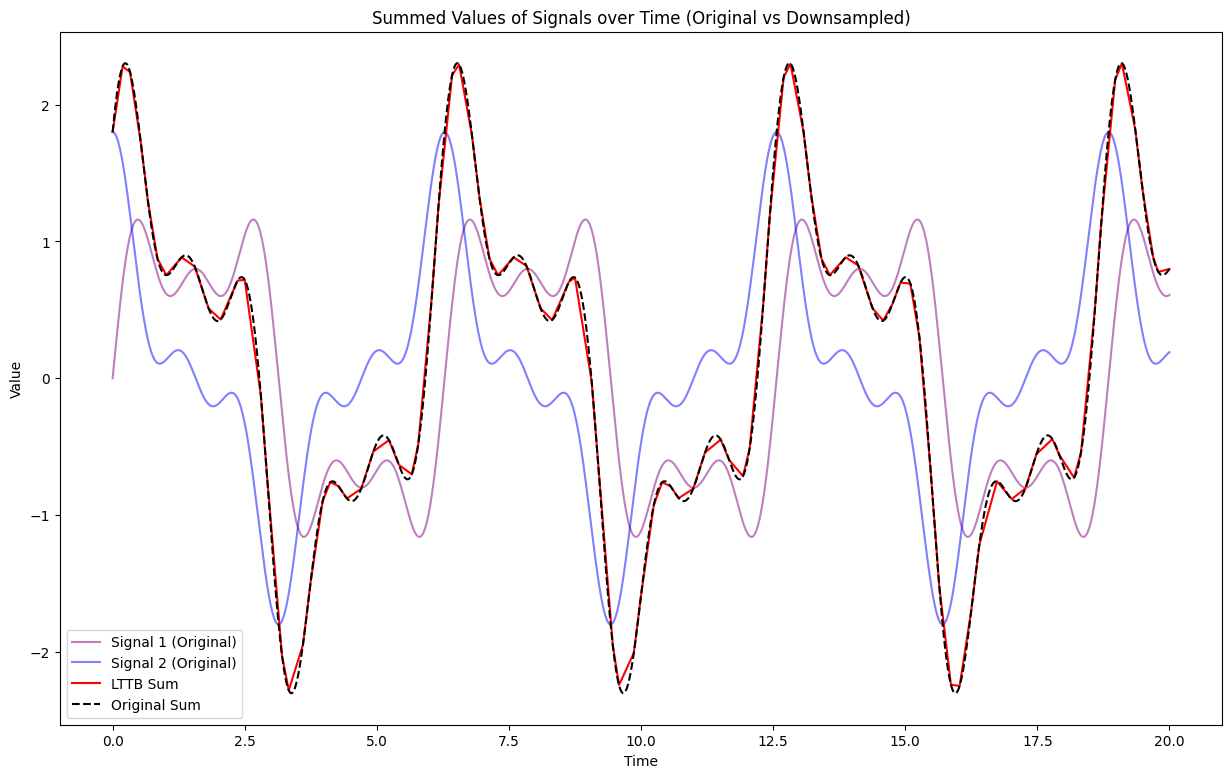

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate signals with added complexity
np.random.seed(42)
number = 1000000  
time = np.linspace(0, 20, number)  

# More complex signals with multiple frequency components
signal_1 = np.sin(time) + 0.5 * np.sin(3 * time) + 0.3 * np.sin(5 * time)
signal_2 = np.cos(time) + 0.5 * np.cos(3 * time) + 0.3 * np.cos(5 * time)

# Create DataFrames
df_signal_1 = pd.DataFrame({"ts": time, "values": signal_1})
df_signal_2 = pd.DataFrame({"ts": time, "values": signal_2})

# Compute the original sum for comparison
original_sum = signal_1 + signal_2

# Process and merge the signals using the function
threshold = 50  # Downsample to reduce data points
merged_df = process_two_signals(df_signal_1, df_signal_2, threshold)

# Interpolating original sum for comparison
from scipy.interpolate import interp1d
interp_func = interp1d(time, original_sum, kind='linear', fill_value='extrapolate')
interpolated_original_sum = interp_func(merged_df['ts'])

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(interpolated_original_sum, merged_df['summed_value']))
mae = mean_absolute_error(interpolated_original_sum, merged_df['summed_value'])
r2 = r2_score(interpolated_original_sum, merged_df['summed_value'])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

# Plot the original, summed, and merged signals
plt.figure(figsize=(15, 9))

# Plot original signals
plt.plot(df_signal_1['ts'], df_signal_1['values'], color='purple', label='Signal 1 (Original)', alpha=0.5)
plt.plot(df_signal_2['ts'], df_signal_2['values'], color='blue', label='Signal 2 (Original)', alpha=0.5)

# Plot merged signals
plt.plot(merged_df['ts'], merged_df['summed_value'], color='red', label='LTTB Sum')

# Plot the original sum
plt.plot(time, original_sum, color='black', label='Original Sum', linestyle='--')

# Finalize the plot
plt.title('Summed Values of Signals over Time (Original vs Downsampled)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

RMSE: 5.801048475926682e-06
MAE: 4.224475829121108e-06
R-squared: 0.9999999999795249


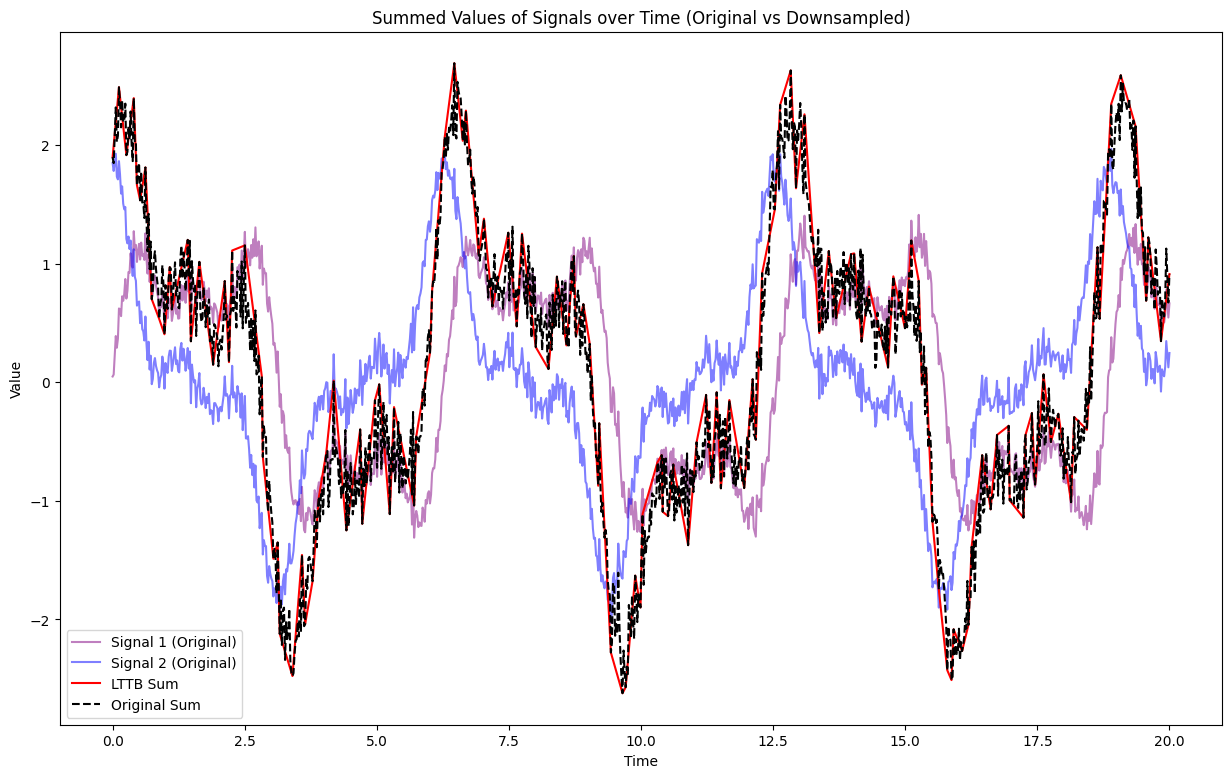

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate signals with added complexity
np.random.seed(42)
number = 1000  
time = np.linspace(0, 20, number)  

# More complex signals with multiple frequency components
signal_1 = np.sin(time) + 0.5 * np.sin(3 * time) + 0.3 * np.sin(5 * time)
signal_2 = np.cos(time) + 0.5 * np.cos(3 * time) + 0.3 * np.cos(5 * time)

# Add some random noise
noise = np.random.normal(0, 0.1, number)
signal_1 += noise
signal_2 += noise

# Create DataFrames
df_signal_1 = pd.DataFrame({"ts": time, "values": signal_1})
df_signal_2 = pd.DataFrame({"ts": time, "values": signal_2})

# Compute the original sum for comparison
original_sum = signal_1 + signal_2

# Process and merge the signals using the function
threshold = 100  # Downsample to reduce data points
merged_df = process_two_signals(df_signal_1, df_signal_2, threshold)

# Interpolating original sum for comparison
from scipy.interpolate import interp1d
interp_func = interp1d(time, original_sum, kind='linear', fill_value='extrapolate')
interpolated_original_sum = interp_func(merged_df['ts'])

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(interpolated_original_sum, merged_df['summed_value']))
mae = mean_absolute_error(interpolated_original_sum, merged_df['summed_value'])
r2 = r2_score(interpolated_original_sum, merged_df['summed_value'])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

# Plot the original, summed, and merged signals
plt.figure(figsize=(15, 9))

# Plot original signals
plt.plot(df_signal_1['ts'], df_signal_1['values'], color='purple', label='Signal 1 (Original)', alpha=0.5)
plt.plot(df_signal_2['ts'], df_signal_2['values'], color='blue', label='Signal 2 (Original)', alpha=0.5)

# Plot merged signals
plt.plot(merged_df['ts'], merged_df['summed_value'], color='red', label='LTTB Sum')

# Plot the original sum
plt.plot(time, original_sum, color='black', label='Original Sum', linestyle='--')

# Finalize the plot
plt.title('Summed Values of Signals over Time (Original vs Downsampled)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()